In [ ]:
!pip install -q ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 55.2 MB/s eta 0:00:00


In [ ]:
# # If you are running on Google Colab, please install TensorFlow 2.0 by uncommenting below..

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Exercise 1: PyTorch Imports Code

In [ ]:
import tensorflow as tf
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

import numpy as np
import torch
import torch.optim as optim
from torchvision import datasets
from ray.tune.examples.mnist_pytorch import train, test, ConvNet, get_data_loaders

import ray
from ray import tune
#from ray.tune import track
from ray.tune.schedulers import AsyncHyperBandScheduler

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("ggplot")

datasets.MNIST("~/data", train=True, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 80357706.47it/s]


Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41258751.30it/s]


Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25163702.70it/s]


Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9734557.37it/s]


Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/data
    Split: Train

In [ ]:
def train_mnist(config):
    model = ConvNet()
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])

    for i in range(20):
        train(model, optimizer, train_loader)  # Train for 1 epoch
        acc = test(model, test_loader)  # Obtain validation accuracy.
        tune.report(mean_accuracy=acc)
        if i % 5 == 0:
            torch.save(model, "./model.pth") # This saves the model to the trial directory

In [ ]:
np.random.seed(1)
search_space = {
    "lr": tune.loguniform(0.0001, 0.1),
    "momentum": tune.uniform(0.1, 0.9)
}

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost.
ray.init(log_to_driver=False)


analysis = tune.run(
    train_mnist,
    config=search_space,
    verbose=1,
    name="train_mnist",  # This is used to specify the logging directory.
    stop={"mean_accuracy": 0.98}  # This will stop the trial
)

2023-07-06 01:23:55,508	INFO worker.py:1636 -- Started a local Ray instance.
2023-07-06 01:23:59,182	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-07-06 01:23:59,190	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-07-06 01:23:59 (running for 00:00:00.28)
Using FIFO scheduling algorithm.
Logical resource usage: 0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/train_mnist
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2023-07-06 01:24:04 (running for 00:00:05.34)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/train_mnist
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2023-07-06 01:24:09 (running for 00:00:10.34)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/train_mnist
Number of trials: 1/1 (1 RUNNING)




2023-07-06 01:24:14,045	INFO tune.py:1111 -- Total run time: 14.92 seconds (14.81 seconds for the tuning loop).


== Status ==
Current time: 2023-07-06 01:24:14 (running for 00:00:14.81)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/train_mnist
Number of trials: 1/1 (1 TERMINATED)




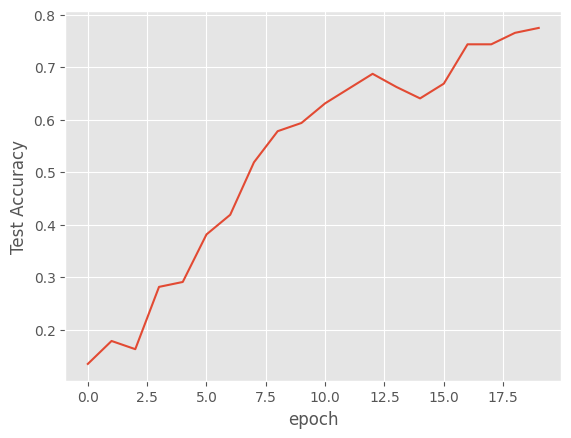

In [ ]:
dfs = analysis.fetch_trial_dataframes()
[d.mean_accuracy.plot() for d in dfs.values()]
plt.xlabel("epoch"); plt.ylabel("Test Accuracy");

In [ ]:
from ray import tune

# Define the search space for hyperparameters
hyperparameter_space = {
    "lr": tune.grid_search([0.001, 0.1, 0.2, 0.3, 0.9]),
    "momentum": tune.grid_search([0.001, 0.1, 0.2, 0.3, 0.9]),
}


In [ ]:
from ray.tune.schedulers import ASHAScheduler

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost.
ray.init(log_to_driver=False)


custom_scheduler = None  # TODO: Add a ASHA as custom scheduler here


analysis = tune.run(
    train_mnist,
    scheduler=custom_scheduler,
    config=hyperparameter_space,
    verbose=1,
    name="train_mnist"  # This is used to specify the logging directory.
)

2023-07-06 01:27:40,336	INFO worker.py:1636 -- Started a local Ray instance.
2023-07-06 01:27:42,542	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-07-06 01:27:42 (running for 00:00:00.33)
Using FIFO scheduling algorithm.
Logical resource usage: 0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/train_mnist
Number of trials: 16/25 (16 PENDING)


== Status ==
Current time: 2023-07-06 01:27:47 (running for 00:00:05.42)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/train_mnist
Number of trials: 16/25 (16 PENDING)


== Status ==
Current time: 2023-07-06 01:27:53 (running for 00:00:10.48)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/train_mnist
Number of trials: 16/25 (16 PENDING)


== Status ==
Current time: 2023-07-06 01:27:58 (running for 00:00:15.50)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/train_mnist
Number of trials: 18/25 (16 PENDING, 2 RUNNING)


== Status ==
Current time: 2023-07-06 01:28:03 (run

2023-07-06 01:30:56,220	INFO tune.py:1111 -- Total run time: 193.72 seconds (193.63 seconds for the tuning loop).


== Status ==
Current time: 2023-07-06 01:30:56 (running for 00:03:13.64)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/train_mnist
Number of trials: 25/25 (25 TERMINATED)




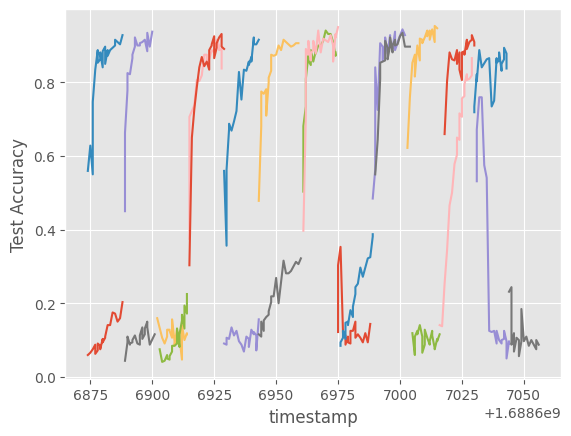

In [ ]:
# Plot by wall-clock time

dfs = analysis.fetch_trial_dataframes()
# This plots everything on the same plot
ax = None
for d in dfs.values():
    ax = d.plot("timestamp", "mean_accuracy", ax=ax, legend=False)
plt.xlabel("timestamp"); plt.ylabel("Test Accuracy");

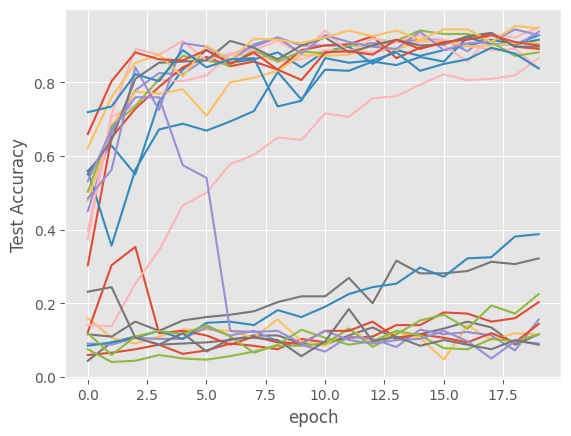

In [ ]:
# Plot by epoch
ax = None
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
plt.xlabel("epoch"); plt.ylabel("Test Accuracy");

In [ ]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

# This is a HyperOpt specific hyperparameter space configuration.
space = {
    "lr": hp.loguniform("lr", -10, -1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
}

# TODO: Create a HyperOptSearch object by passing in a HyperOpt specific search space.
# Also enforce that only 1 trials can run concurrently.
hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

# We Remove the dir so that we can visualize tensorboard correctly
! rm -rf ~/ray_results/search_algorithm
analysis = tune.run(
    train_mnist,
    num_samples=10,
    search_alg=hyperopt_search,  # Change this line
    verbose=1,
    name="search_algorithm"
)

2023-07-06 01:40:36,396	WARNING callback.py:144 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2023-07-06 01:40:36 (running for 00:00:00.12)
Using FIFO scheduling algorithm.
Logical resource usage: 0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/search_algorithm
Number of trials: 1/10 (1 PENDING)


== Status ==
Current time: 2023-07-06 01:40:41 (running for 00:00:05.21)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/search_algorithm
Number of trials: 1/10 (1 PENDING)


== Status ==
Current time: 2023-07-06 01:40:46 (running for 00:00:10.28)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/search_algorithm
Number of trials: 2/10 (1 PENDING, 1 RUNNING)


== Status ==
Current time: 2023-07-06 01:40:51 (running for 00:00:15.30)
Using FIFO scheduling algorithm.
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/search_algorithm
Number of trials: 2/10 (1 PENDING, 1 RUNNING)


== Status ==
Current time: 2

2023-07-06 01:42:10,601	INFO tune.py:1111 -- Total run time: 94.22 seconds (94.18 seconds for the tuning loop).


== Status ==
Current time: 2023-07-06 01:42:10 (running for 00:01:34.18)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Result logdir: /root/ray_results/search_algorithm
Number of trials: 10/10 (10 TERMINATED)


